# Bayesian Neural Networks - dropout

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import theano
import theano.tensor as T
import pymc3 as pm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets
from scipy import optimize
from scipy.stats import mode

import lasagne
from lasagne.nonlinearities import softmax, tanh
import seaborn as sns

from utils import plot_confusion_matrix, print_precision_recall_fscore, plot_prediction_surface

plt.style.use('ggplot')

In [2]:
X, Y = datasets.make_classification(
    n_samples=500, 
    n_features=30,
    n_informative=4,
    n_redundant=0, 
    n_repeated=0,
    n_classes=3,
    random_state=0)

In [3]:
X = StandardScaler().fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.75, random_state=0)

In [4]:
feature_columns = np.arange(X.shape[1])
target_column = 'target'
df = pd.DataFrame(np.concatenate([X, np.vstack(Y)], axis=1), columns=np.concatenate([feature_columns, [target_column]]))
df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,target
0,-0.979420,2.138619,-0.486284,-1.830086,-1.204627,-0.222592,-0.469964,1.448594,-0.620208,0.665207,...,0.237348,-0.875030,0.102316,-0.711561,1.798499,-2.297465,-0.287922,1.045633,-1.384609,2.0
1,2.101579,-1.446815,-0.320401,1.341267,-0.259928,-0.550794,-0.291625,-0.644712,0.845688,0.301633,...,-2.121712,0.611640,-1.252245,0.861240,-1.691402,-0.719888,1.235704,1.151269,-0.810683,1.0
2,-0.030374,-1.022406,-1.344548,0.140543,0.704665,-0.059344,-0.776124,0.850838,-1.485805,0.016100,...,0.892403,0.984727,0.622408,0.631809,1.116605,0.363543,-0.201825,1.056901,-0.258531,0.0
3,-0.614972,0.750161,-0.413827,-0.373841,-1.152890,-0.034618,-0.344490,0.569063,-0.664714,-1.421195,...,-0.164974,0.761485,0.912548,0.412073,-1.013495,-1.588506,-0.745824,0.870075,-1.570283,0.0
4,3.384099,0.438807,-1.458107,0.397843,-0.633817,1.327337,0.688351,0.374844,0.197003,0.067561,...,1.145027,-0.930314,0.373318,0.554891,0.078435,-0.465406,1.315211,-0.926699,-1.066776,0.0


### Plot data

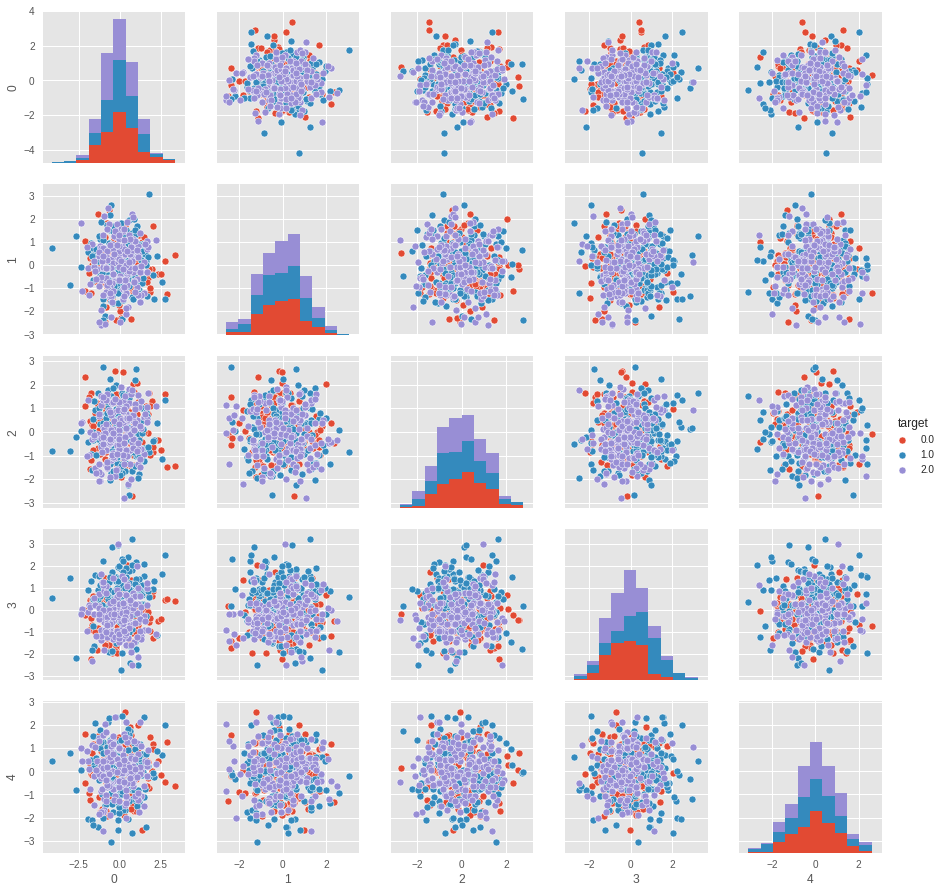

In [5]:
sns.pairplot(data=df, vars=feature_columns[:5].astype(str), hue=target_column);

## Build model

In [6]:
n_hidden = 5

In [7]:
def build_nn_L2_dropout(X_shared, y_shared, n_hidden):

    in_shape = X_shared.get_value().shape
    n_in = in_shape[1]
    n_out = len(np.unique(y_shared.get_value()))

    with pm.Model() as model:

        # weights with L2 normalization
        w_in_1 = pm.Normal('w_in_1', 0, sd=1, shape=(n_in, n_hidden), testval=np.random.randn(n_in, n_hidden))
        w_1_2 = pm.Normal('w_1_2', 0, sd=1, shape=(n_hidden, n_hidden), testval=np.random.randn(n_hidden, n_hidden))
        w_2_out = pm.Normal('w_2_out', 0, sd=1, shape=(n_hidden, n_out), testval=np.random.randn(n_hidden, n_out))

        # dropout
        d_in_1 = pm.Bernoulli('d_in_1', p=0.5, shape=n_in, testval=1)
        d_1_2 = pm.Bernoulli('d_1_2', p=0.5, shape=n_hidden, testval=1)
        d_2_out = pm.Bernoulli('d_2_out', p=0.5, shape=n_hidden, testval=1)
        
        # layers
        l_in = lasagne.layers.InputLayer(in_shape, input_var=X_shared)
        l_1 = lasagne.layers.DenseLayer(l_in, n_hidden, W=T.dot(T.nlinalg.diag(d_in_1), w_in_1), nonlinearity=tanh)
        l_2 = lasagne.layers.DenseLayer(l_1, n_hidden, W=T.dot(T.nlinalg.diag(d_1_2), w_1_2), nonlinearity=tanh)
        l_out = lasagne.layers.DenseLayer(l_2, n_out, W=T.dot(T.nlinalg.diag(d_2_out), w_2_out), nonlinearity=softmax)

        p = pm.Deterministic('p', lasagne.layers.get_output(l_out))
        out = pm.Categorical('out', p=p, observed=y_shared)
        
    return model

## Training

In [8]:
def train(model):
    with model:    
        # pymc3 will automatically assign sampling method
        # (no estimation + NUTS + BinaryGibbsMetropolis) for combination of continous & binary variables
        trace_ = pm.sample(1000, n_init=100000, tune=500)
        trace = trace_[500::2]
    return trace

In [9]:
def predict_classes(model, trace):
    # Creater posterior predictive samples
    with model:
        ppc = pm.sample_ppc(trace, samples=100)
    
    # in case we have multiple classes, calculate mode (not mean)
    return mode(ppc['out'], axis=0).mode[0, :]

In [10]:
def train_evaluate(build, n_hidden):
    X_shared = theano.shared(X_train)
    y_shared = theano.shared(Y_train)

    model = build(X_shared, y_shared, n_hidden)
    trace = train(model)

    # in sample validation
    Y_train_pred = predict_classes(model, trace)
    plot_confusion_matrix(Y_train, Y_train_pred)
    print_precision_recall_fscore(Y_train, Y_train_pred)

    # out of sample validation
    X_shared.set_value(X_test)
    y_shared.set_value(Y_test)

    Y_test_pred = predict_classes(model, trace)
    plot_confusion_matrix(Y_test, Y_test_pred)
    print_precision_recall_fscore(Y_test, Y_test_pred)

    return model, trace, Y_test_pred

## Training BNN model

Assigned NUTS to w_in_1
Assigned NUTS to w_1_2
Assigned NUTS to w_2_out
Assigned BinaryGibbsMetropolis to d_in_1
Assigned BinaryGibbsMetropolis to d_1_2
Assigned BinaryGibbsMetropolis to d_2_out
100%|██████████| 100/100 [00:00<00:00, 175.63it/s]


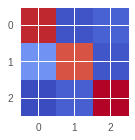

  6%|▌         | 6/100 [00:00<00:01, 52.27it/s]

Precision: [ 0.85        0.93023256  0.92857143] 0.902934662237
Recall: [ 0.91891892  0.85106383  0.95121951] 0.9070674203
F-score: [ 0.88311688  0.88888889  0.93975904] 0.903921602717


100%|██████████| 100/100 [00:01<00:00, 88.14it/s]


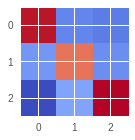

Precision: [ 0.76984127  0.65254237  0.72519084] 0.715858160806
Recall: [ 0.74615385  0.64166667  0.76      ] 0.71594017094
F-score: [ 0.7578125   0.64705882  0.7421875 ] 0.71568627451


In [11]:
model, trace, pred = train_evaluate(build_nn_L2_dropout, n_hidden)

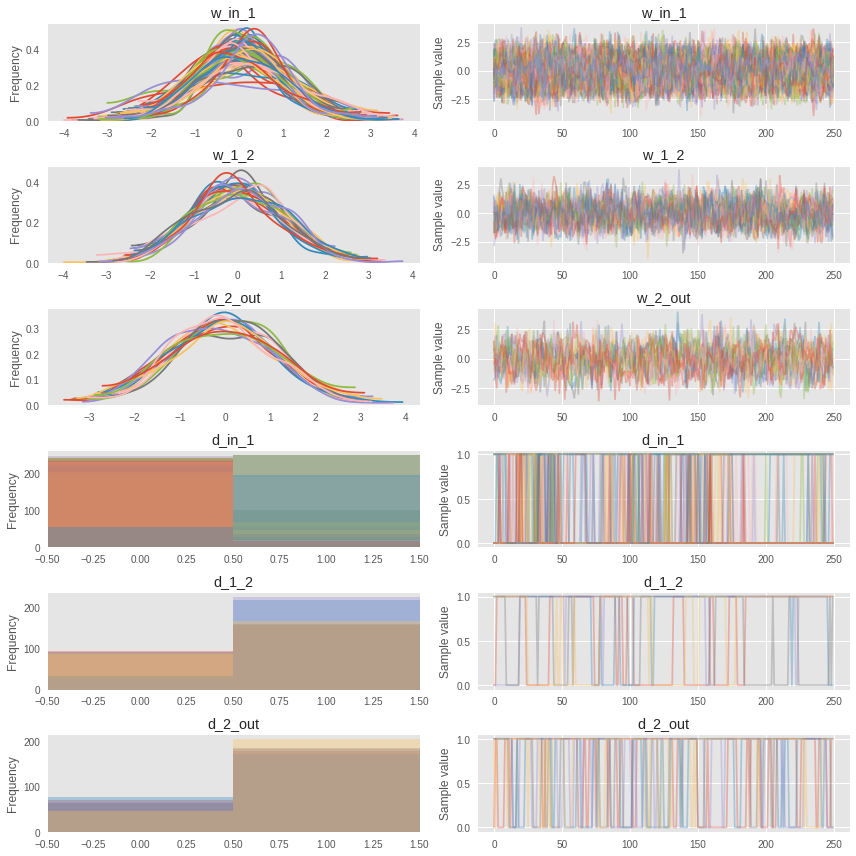

In [12]:
pm.traceplot(trace, varnames=trace.varnames[:len(trace.varnames)-1]);

---

## Visualizing neuron dropouts and weights

In [13]:
trace_w_in_1 = trace['w_in_1'].mean(axis=0).T
trace_w_1_2 = trace['w_1_2'].mean(axis=0).T
trace_w_2_out = trace['w_2_out'].mean(axis=0).T

trace_d_in_1 = np.repeat(np.vstack(trace['d_in_1'].mean(axis=0)).T, trace_w_in_1.shape[0], axis=0)
trace_d_1_2 = np.repeat(np.vstack(trace['d_1_2'].mean(axis=0)).T, trace_w_1_2.shape[0], axis=0)
trace_d_2_out = np.repeat(np.vstack(trace['d_2_out'].mean(axis=0)).T, trace_w_2_out.shape[0], axis=0)

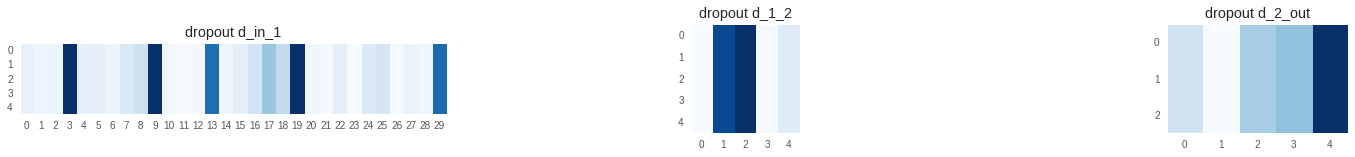

In [14]:
fig, ax = plt.subplots(1,3, figsize=(26,2))

ax[0].grid(False)
ax[0].imshow(trace_d_in_1, cmap=plt.cm.Blues)
ax[0].set_xticks(np.arange(0, trace_d_in_1.shape[1], 1));
ax[0].set_yticks(np.arange(0, trace_d_in_1.shape[0], 1));
ax[0].set_title('dropout d_in_1');

ax[1].grid(False)
ax[1].imshow(trace_d_1_2, cmap=plt.cm.Blues)
ax[1].set_xticks(np.arange(0, trace_d_1_2.shape[1], 1));
ax[1].set_yticks(np.arange(0, trace_d_1_2.shape[0], 1));
ax[1].set_title('dropout d_1_2');

ax[2].grid(False)
ax[2].imshow(trace_d_2_out, cmap=plt.cm.Blues)
ax[2].set_xticks(np.arange(0, trace_d_2_out.shape[1], 1));
ax[2].set_yticks(np.arange(0, trace_d_2_out.shape[0], 1));
ax[2].set_title('dropout d_2_out');

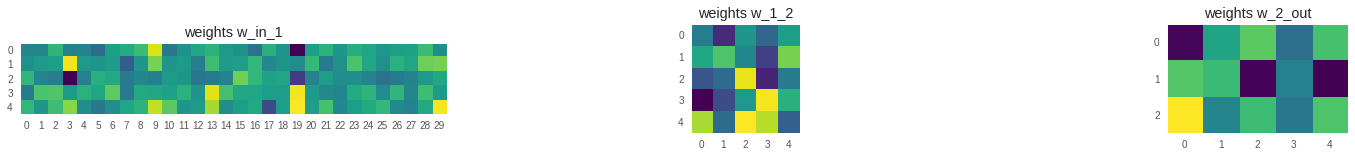

In [15]:
fig, ax = plt.subplots(1,3, figsize=(26,2))

ax[0].grid(False)
ax[0].imshow(trace_w_in_1, cmap=plt.cm.viridis)
ax[0].set_xticks(np.arange(0, trace_w_in_1.shape[1], 1));
ax[0].set_yticks(np.arange(0, trace_w_in_1.shape[0], 1));
ax[0].set_title('weights w_in_1');

ax[1].grid(False)
ax[1].imshow(trace_w_1_2, cmap=plt.cm.viridis)
ax[1].set_xticks(np.arange(0, trace_w_1_2.shape[1], 1));
ax[1].set_yticks(np.arange(0, trace_w_1_2.shape[0], 1));
ax[1].set_title('weights w_1_2');

ax[2].grid(False)
ax[2].imshow(trace_w_2_out, cmap=plt.cm.viridis)
ax[2].set_xticks(np.arange(0, trace_w_2_out.shape[1], 1));
ax[2].set_yticks(np.arange(0, trace_w_2_out.shape[0], 1));
ax[2].set_title('weights w_2_out');

---

## Compare with Keras

In [16]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout
from keras.optimizers import SGD

m = Sequential()
m.add(Dense(n_hidden, input_dim=X_train.shape[1], activation='tanh'))
m.add(Dropout(0.5))
m.add(Dense(n_hidden, activation='tanh'))
m.add(Dropout(0.5))
m.add(Dense(3, kernel_initializer='normal', activation='softmax'))

m.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='sgd')

m.fit(X_train, Y_train, epochs=2000, verbose=False)

Using TensorFlow backend.


 32/125 [======>.......................] - ETA: 0s

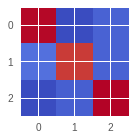

Precision: [ 0.92105263  0.95454545  0.90697674] 0.927524943437
Recall: [ 0.94594595  0.89361702  0.95121951] 0.930260826473
F-score: [ 0.93333333  0.92307692  0.92857143] 0.928327228327


In [17]:
Y_train_pred = m.predict_classes(X_train)
plot_confusion_matrix(Y_train, Y_train_pred)
print_precision_recall_fscore(Y_train, Y_train_pred)

 32/375 [=>............................] - ETA: 0s

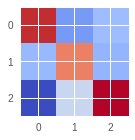

Precision: [ 0.69230769  0.52892562  0.59124088] 0.604158062685
Recall: [ 0.62307692  0.53333333  0.648     ] 0.60147008547
F-score: [ 0.65587045  0.53112033  0.61832061] 0.60177046266


In [18]:
Y_test_pred = m.predict_classes(X_test)
plot_confusion_matrix(Y_test, Y_test_pred)
print_precision_recall_fscore(Y_test, Y_test_pred)

### Using approximated dropout rate for feature selection

In [19]:
mask = trace_d_in_1[0] > 0.5
X_train[:,mask].shape

(125, 5)

In [20]:
m = Sequential()
m.add(Dense(n_hidden, input_dim=X_train[:,mask].shape[1], activation='tanh'))
m.add(Dropout(0.5))
m.add(Dense(n_hidden, activation='tanh'))
m.add(Dropout(0.5))
m.add(Dense(3, kernel_initializer='normal', activation='softmax'))

m.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='sgd')

m.fit(X_train[:,mask], Y_train, epochs=2000, verbose=False)

 32/125 [======>.......................] - ETA: 0s

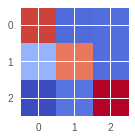

Precision: [ 0.775       0.83333333  0.86046512] 0.822932816537
Recall: [ 0.83783784  0.74468085  0.90243902] 0.828319237764
F-score: [ 0.80519481  0.78651685  0.88095238] 0.824221346693


In [21]:
Y_train_pred = m.predict_classes(X_train[:,mask])
plot_confusion_matrix(Y_train, Y_train_pred)
print_precision_recall_fscore(Y_train, Y_train_pred)

 32/375 [=>............................] - ETA: 0s

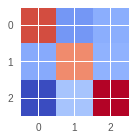

Precision: [ 0.78070175  0.60169492  0.65734266] 0.679913108994
Recall: [ 0.68461538  0.59166667  0.752     ] 0.676094017094
F-score: [ 0.7295082   0.59663866  0.70149254] 0.675879796499


In [22]:
Y_test_pred = m.predict_classes(X_test[:,mask])
plot_confusion_matrix(Y_test, Y_test_pred)
print_precision_recall_fscore(Y_test, Y_test_pred)

**Observe**

- Number of nodes on first layer with dropout rate > 0.5 is close to number of informative features
- After feature selection overfit decreased from ~0.30 to ~0.15